## Background Removal using Singular Value Decomposition (SVD)

In [1]:
import imageio
imageio.plugins.ffmpeg.download()

import moviepy.editor as mpe
import numpy as np
import scipy

%matplotlib inline
import matplotlib.pyplot as plt

### Read in video

In [2]:
np.set_printoptions(precision=4, suppress=True)

In [3]:
video = mpe.VideoFileClip("RowerWeedonIsland.MTS")

In [4]:
video.size

[1440, 1080]

In [5]:
video.duration

57.09

### Create matrix M

Each column of M is a flattened image in the video.

In [6]:
def create_data_matrix_from_video(clip, dims, fps=5):
    return np.vstack([scipy.misc.imresize(rgb2gray(clip.get_frame(i/float(fps))).astype(int), 
                      dims).flatten() for i in range(fps * int(clip.duration))]).T

In [7]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [8]:
scale = 0.10   # Adjust scale to change resolution of image
dims = (int(1440 * scale), int(1080 * scale))
fps = 10      # frames per second

In [9]:
%time M = create_data_matrix_from_video(video.subclip(0,100), dims, fps)

CPU times: user 1min 15s, sys: 20.3 s, total: 1min 35s
Wall time: 1min 50s


In [10]:
print(dims, M.shape)

(144, 108) (15552, 1000)


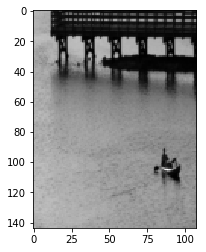

In [11]:
plt.imshow(np.reshape(M[:,10], dims), cmap='gray');

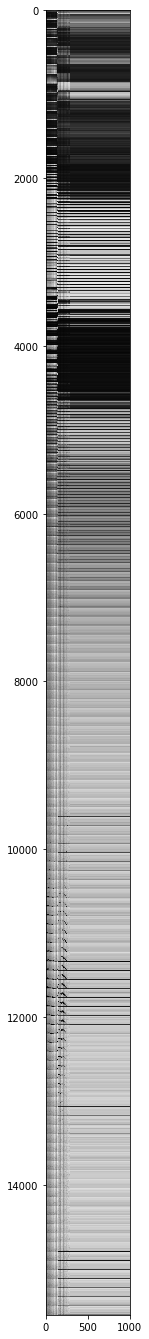

In [12]:
plt.figure(figsize=(24, 24))
plt.imshow(M, cmap='gray')

In [13]:
np.save('matrix_60fps.npy', M)

In [14]:
M = np.load("matrix_60fps.npy")

### Full SVD

We perform a full SVD on matrix M, and then use the first rank to reconstruct the background. 

In [15]:
%time U, s, V = np.linalg.svd(M, full_matrices=False)

CPU times: user 6.46 s, sys: 420 ms, total: 6.88 s
Wall time: 1.86 s


In [16]:
low_rank = np.expand_dims(U[:,0], 1) * s[0] * np.expand_dims(V[0,:], 0)

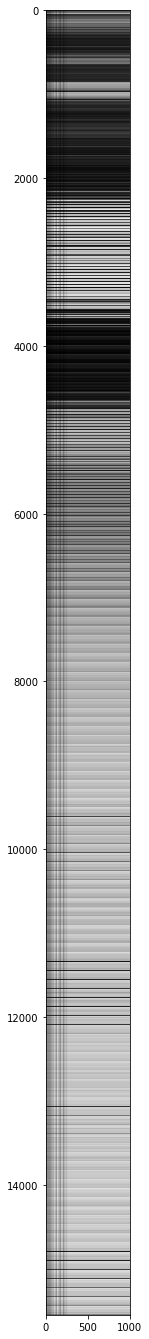

In [17]:
plt.figure(figsize=(24, 24))
plt.imshow(low_rank, cmap='gray')

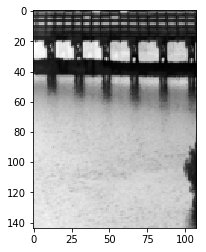

In [18]:
# background
plt.imshow(np.reshape(low_rank[:,0], dims), cmap='gray')

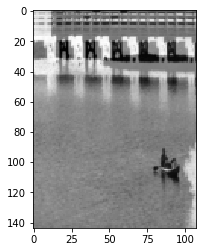

In [19]:
# moving part
plt.imshow(np.reshape(M[:,0] - low_rank[:,0], dims), cmap='gray')

#### Make video for moving part

In [20]:
from moviepy.video.io.bindings import mplfig_to_npimage

In [21]:
def make_video(matrix, dims, filename):
    mat_reshaped = np.reshape(matrix, (dims[0], dims[1], -1))
    
    fig, ax = plt.subplots()
    def make_frame(t):
        ax.clear()
        ax.imshow(mat_reshaped[...,int(t*fps)])
        return mplfig_to_npimage(fig)
    
    animation = mpe.VideoClip(make_frame, duration=int(10))
    animation.write_videofile(filename + '.mp4', fps=fps)

[MoviePy] >>>> Building video moving_part.mp4
[MoviePy] Writing video moving_part.mp4


 99%|█████████▉| 100/101 [00:04<00:00, 22.56it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: moving_part.mp4 



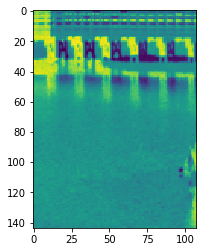

In [22]:
make_video(M - low_rank, dims, "moving_part")

In [23]:
mpe.VideoFileClip("moving_part.mp4").subclip(0,10).ipython_display(width=300)

 99%|█████████▉| 100/101 [00:00<00:00, 999.48it/s]


[MoviePy] >>>> Building video background.mp4
[MoviePy] Writing video background.mp4


 99%|█████████▉| 100/101 [00:04<00:00, 23.58it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: background.mp4 



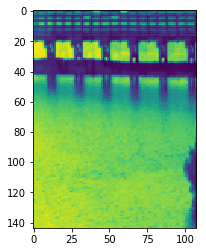

In [24]:
make_video(low_rank, dims, "background")

In [25]:
mpe.VideoFileClip("background.mp4").subclip(0,10).ipython_display(width=300)

 99%|█████████▉| 100/101 [00:00<00:00, 1078.96it/s]


### Randomized SVD (use a smaller matrix)

In [26]:
def simple_randomized_svd(M, k=5):
    m, n = M.shape
    transpose = False
    if m < n:
        transpose = True
        M = M.T
        
    rand_matrix = np.random.normal(size=(M.shape[1], k))  # short side by k
    Q, _ = np.linalg.qr(M @ rand_matrix, mode='reduced')  # long side by k
    smaller_matrix = Q.T @ M                              # k by short side
    U_hat, s, V = np.linalg.svd(smaller_matrix, full_matrices=False)
    U = Q @ U_hat
    
    if transpose:
        return V.T, s.T, U.T
    else:
        return U, s, V

In [27]:
%time U_rand, s_rand, V_rand = simple_randomized_svd(M, 5)

CPU times: user 315 ms, sys: 82.2 ms, total: 397 ms
Wall time: 157 ms


This method is much faster than performing a full SVD!

In [28]:
low_rank_rand = np.expand_dims(U_rand[:,0], 1) * s_rand[0] * np.expand_dims(V_rand[0,:], 0)

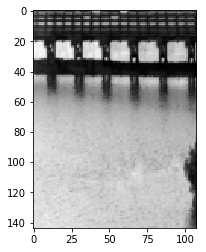

In [29]:
# background
plt.imshow(np.reshape(low_rank_rand[:,0], dims), cmap='gray');

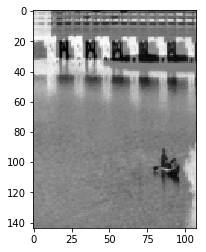

In [30]:
# moving part
plt.imshow(np.reshape(M[:,0] - low_rank_rand[:,0], dims), cmap='gray');

[MoviePy] >>>> Building video moving_part_rand.mp4
[MoviePy] Writing video moving_part_rand.mp4


 99%|█████████▉| 100/101 [00:04<00:00, 22.74it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: moving_part_rand.mp4 



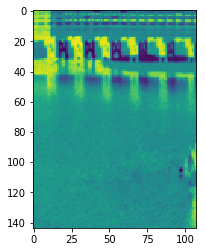

In [31]:
make_video(M - low_rank_rand, dims, "moving_part_rand")

In [32]:
mpe.VideoFileClip("moving_part_rand.mp4").subclip(0,10).ipython_display(width=300)

 99%|█████████▉| 100/101 [00:00<00:00, 1080.12it/s]


[MoviePy] >>>> Building video background_rand.mp4
[MoviePy] Writing video background_rand.mp4


 99%|█████████▉| 100/101 [00:04<00:00, 20.36it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: background_rand.mp4 



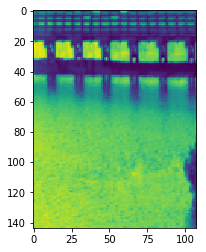

In [33]:
make_video(low_rank_rand, dims, "background_rand")

In [34]:
mpe.VideoFileClip("background_rand.mp4").subclip(0,10).ipython_display(width=300)

 99%|█████████▉| 100/101 [00:00<00:00, 603.81it/s]


This method gives us acceptable results in a much shorter time!